# Forecast Performance Analysis

This notebook evaluates model performance across different forecast lead times (1, 5, and 10 days) using NSE as the primary metric.

In [1]:
from transfer_learning_publication.evaluation import MetricCalculator
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better-looking plots
sns.set_context("paper", font_scale=1.3)
plt.rcParams['figure.figsize'] = (10, 5)

## Load Predictions and Compute Metrics

Load all prediction parquet files from the evaluation results and compute NSE grouped by model, basin, and lead time.

In [2]:
# Load predictions from all models
calc = MetricCalculator.from_parquet(
    "../results/evaluation/natural_basins/model_name=*/seed=*/predictions.parquet"
)

# Compute NSE grouped by model, basin, and lead time
metrics = calc.compute_metrics(
    metrics=["nse"],
    group_by=["model_name", "group_identifier", "lead_time"],
    exclude_filled=True
)

print(f"Computed metrics for {metrics.height} combinations")
print(f"\nMetrics shape: {metrics.shape}")
metrics.head(10)

Computed metrics for 22640 combinations

Metrics shape: (22640, 4)


model_name,group_identifier,lead_time,NSE
str,str,i64,f64
"""ealstm_natural""","""camels_01013500""",1,0.971339
"""ealstm_natural""","""camels_01013500""",2,0.916386
"""ealstm_natural""","""camels_01013500""",3,0.87478
"""ealstm_natural""","""camels_01013500""",4,0.835308
"""ealstm_natural""","""camels_01013500""",5,0.81294
"""ealstm_natural""","""camels_01013500""",6,0.800877
"""ealstm_natural""","""camels_01013500""",7,0.771698
"""ealstm_natural""","""camels_01013500""",8,0.741887
"""ealstm_natural""","""camels_01013500""",9,0.716732


## Filter to Lead Times of Interest

Focus on lead times 1, 5, and 10 days to analyze performance degradation.

In [3]:
# Filter to lead times 1, 5, and 10
metrics_filtered = metrics.filter(
    pl.col("lead_time").is_in([1, 5, 10])
)

# Remove any NaN values for cleaner visualization
metrics_clean = metrics_filtered.filter(
    ~pl.col("NSE").is_nan()
)

print(f"Filtered metrics shape: {metrics_clean.shape}")
print(f"\nModels: {metrics_clean['model_name'].unique().sort().to_list()}")
print(f"Lead times: {metrics_clean['lead_time'].unique().sort().to_list()}")
print(f"Number of basins: {metrics_clean['group_identifier'].n_unique()}")

Filtered metrics shape: (6792, 4)

Models: ['ealstm_natural', 'tft_natural', 'tide_natural', 'tsmixer_natural']
Lead times: [1, 5, 10]
Number of basins: 566


## Summary Statistics

Quick overview of NSE performance by model and lead time.

In [4]:
# Summary statistics
summary = (
    metrics_clean
    .group_by(["model_name", "lead_time"])
    .agg([
        pl.col("NSE").mean().alias("NSE_mean"),
        pl.col("NSE").median().alias("NSE_median"),
        pl.col("NSE").std().alias("NSE_std"),
        pl.len().alias("n_basins")
    ])
    .sort(["model_name", "lead_time"])
)

print(summary)

shape: (12, 6)
┌─────────────────┬───────────┬──────────┬────────────┬──────────┬──────────┐
│ model_name      ┆ lead_time ┆ NSE_mean ┆ NSE_median ┆ NSE_std  ┆ n_basins │
│ ---             ┆ ---       ┆ ---      ┆ ---        ┆ ---      ┆ ---      │
│ str             ┆ i64       ┆ f64      ┆ f64        ┆ f64      ┆ u32      │
╞═════════════════╪═══════════╪══════════╪════════════╪══════════╪══════════╡
│ ealstm_natural  ┆ 1         ┆ 0.871763 ┆ 0.907983   ┆ 0.133871 ┆ 566      │
│ ealstm_natural  ┆ 5         ┆ 0.699983 ┆ 0.734638   ┆ 0.200771 ┆ 566      │
│ ealstm_natural  ┆ 10        ┆ 0.64502  ┆ 0.676991   ┆ 0.212062 ┆ 566      │
│ tft_natural     ┆ 1         ┆ 0.891896 ┆ 0.924619   ┆ 0.124921 ┆ 566      │
│ tft_natural     ┆ 5         ┆ 0.777783 ┆ 0.815499   ┆ 0.188885 ┆ 566      │
│ …               ┆ …         ┆ …        ┆ …          ┆ …        ┆ …        │
│ tide_natural    ┆ 5         ┆ 0.737742 ┆ 0.776833   ┆ 0.212178 ┆ 566      │
│ tide_natural    ┆ 10        ┆ 0.693293 ┆ 0.7276

## Boxplot: NSE by Lead Time and Model

Visualize the distribution of NSE across basins for each model at each lead time.

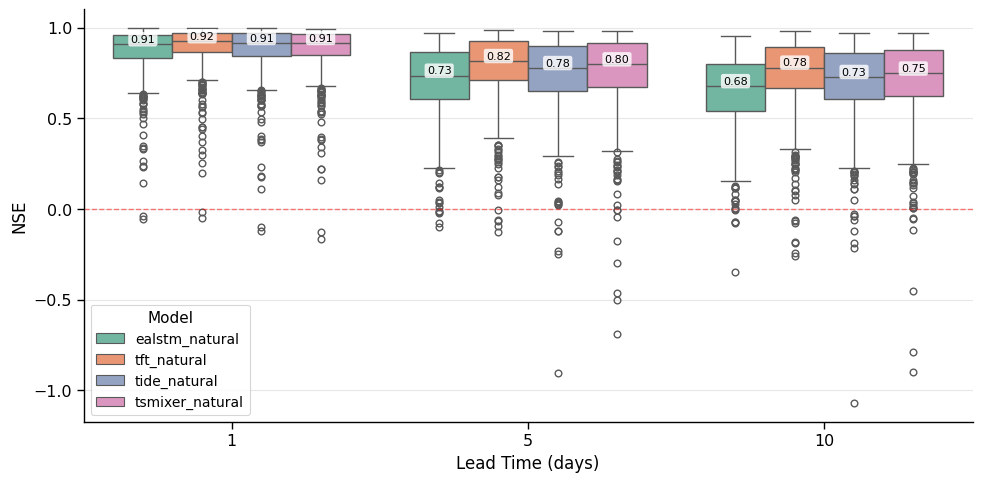

In [7]:
# Convert to pandas for seaborn compatibility
df_plot = metrics_clean.to_pandas()

# Create boxplot
fig, ax = plt.subplots(figsize=(10, 5))

sns.boxplot(
    data=df_plot,
    x="lead_time",
    y="NSE",
    hue="model_name",
    ax=ax,
    palette="Set2"
)

# Customize plot
ax.set_xlabel("Lead Time (days)", fontsize=12)
ax.set_ylabel("NSE", fontsize=12)
ax.legend(title="Model", fontsize=10, title_fontsize=11)
ax.grid(axis='y', alpha=0.3)

# Add horizontal line at NSE=0 (baseline performance)
ax.axhline(y=0, color='red', linestyle='--', alpha=0.5, linewidth=1, label='Baseline (NSE=0)')

# Add median annotations using the summary dataframe
summary_pd = summary.to_pandas()

# Get unique lead times and models to determine positions
lead_times = sorted(df_plot['lead_time'].unique())
models = df_plot['model_name'].unique()
n_models = len(models)

for i, lead_time in enumerate(lead_times):
    for j, model in enumerate(models):
        median_val = summary_pd[
            (summary_pd['lead_time'] == lead_time) & 
            (summary_pd['model_name'] == model)
        ]['NSE_median'].values
        
        if len(median_val) > 0:
            median_val = median_val[0]
            
            offset = (j - n_models / 2 + 0.5) * (0.8 / n_models)
            x_pos = i + offset
            
            # Add annotation
            ax.text(
                x_pos, median_val,
                f'{median_val:.2f}',
                ha='center', va='bottom',
                fontsize=8, color='black',
                bbox=dict(boxstyle='round,pad=0.2', facecolor='white', edgecolor='none', alpha=0.8)
            )

plt.tight_layout()
sns.despine()
plt.show()